**TIME SERIES ANALYSIS**

Goal: Find outliers, trends and periodicity in the MTA turnstile data

DATA: MTA subway fares. It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.

The data was organized by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy.
It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows:

In [43]:
# image to be put in github repo

#from IPython.display import Image
#Image(filename = "Ridetypes.png")

In [45]:
from __future__ import print_function

import numpy as np
import pandas as pd
import pylab as pl
import os
import json
%pylab inline
import datetime
import urllib2
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


Populating the interactive namespace from numpy and matplotlib


Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014.

The data are available to you as a python data cube here:
you can load it as np.load(“MTA_Fare.npy") and you will end up with a python numpy array of shape (600,23,194)

In [46]:
#fare = np.load('http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy') # can't seem to load from site...

#data = urllib2.urlopen('http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy

fare = np.load('C:\Users\Maria\Downloads\MTA_Fare.npy')
#print fare[50] # checking data
fare.shape # confirms 600 stations, 23 cardtypes, 194weeks of data

(600L, 23L, 194L)

next step - clean data

note that the missing values are inputted as -1
if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans: np.nanmean np.nansum...

In [47]:
# replace -1 values with Nan
faredata = where(fare<0, 'NaN', fare)
#print "1. ",type(faredata)
#print faredata

#check code was executed correctly
faredata.shape
#print faredata [10] # first 10 arrays?
faredata = faredata.astype(float)
#print "2. ",type(faredata)
#print faredata

swipes = np.nansum(faredata, axis=1) # take NaN values so they don't default to zeros and add to first axis, were NaNs all fare types?
#print "Here",mtastations


In [48]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [49]:
# update date field so data is grouped by week, use panda date/time for this

weekly = pd.date_range('05/21/2010', periods=194, freq='W')
weekly.shape

(194L,)

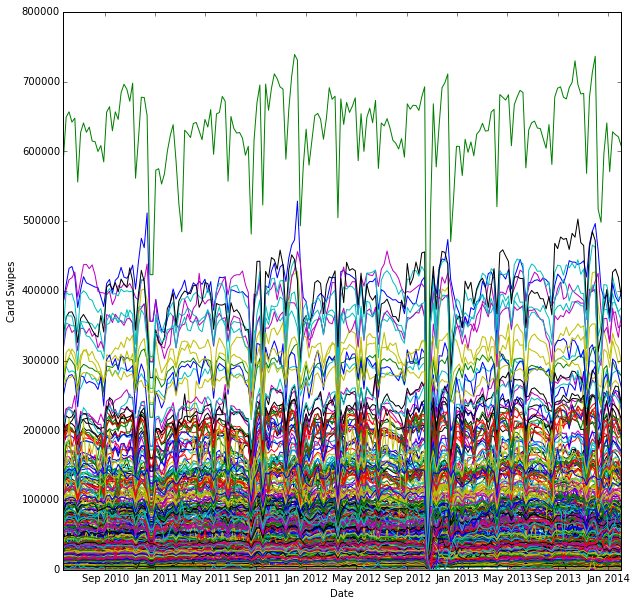

In [50]:
# identify prominent event

plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(weekly, np.transpose(swipes))
#we used transpose to get the time on the x axis
pl.ylabel('Card Swipes')
pl.xlabel('Date')

**Task 1:**

Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.

Answer:
The event is due to Hurricane Sandy.
Finding this mathematically we must first find means and standard deviations.

In [51]:
# mean
swipes_mean = np.nanmean(swipes, axis = 1)
swipes_mean.shape
#print swipes_mean

# standard deviation
swipes_std = np.nanstd(swipes, axis = 1)
swipes_std.shape
#print swipes_std

(600L,)

In [52]:
# find the data (weeks away from mean) that is greater than and less than 3 standard deviations

swipes_upper = swipes_mean + 3*swipes_std
swipes_lower = swipes_mean - 3*swipes_std

#print swipes_upper, swipes_lower

In [53]:
# location wasn't working, this is the code tried
#locupper = np.where(swipes < swipes_upper)
#print locupper

In [54]:
# had help from classmates on creating loop 
event = [np.where(ts < swipes_lower[i]) for i,ts in enumerate(swipes)]
#print event[0]

Weeks 127 - 130 in the dataset are the end of October 2012 (Hurricane Sandy)

In [55]:
# checking upper bound
event2 = [np.where(ts > swipes_upper[i]) for i, ts in enumerate(swipes)]
#print event2[0]

# does not print any weeks, no significant event where unually large subway ridership occured

**Task 2:**

Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [56]:
#similar to task 1 but this time using ridertype, so sum on axis = 0, which refers to the 23 types
faretype = np.nansum(faredata, axis=0)
faretype.shape # 23 fare types for 194 weeks

(23L, 194L)

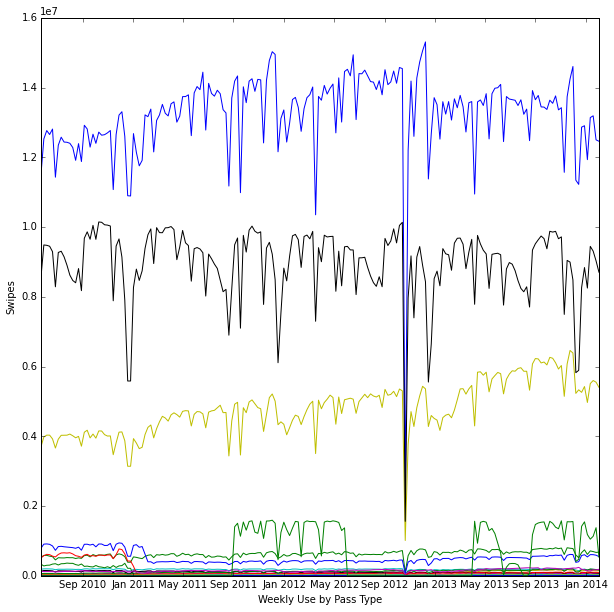

In [26]:
# plot data

plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(weekly, np.transpose(faretype))
pl.ylabel('Swipes')
pl.xlabel('Weekly Use by Pass Type')

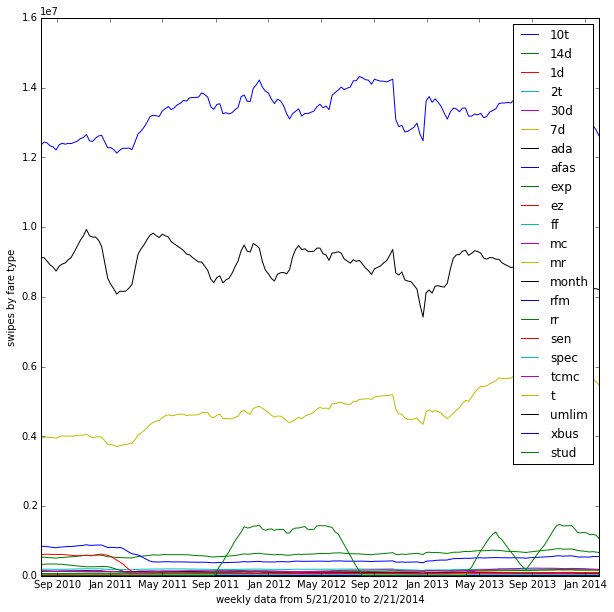

In [27]:
# rolling mean as suggested by FB instructions

plt.figure(figsize=(10, 10), dpi=200)
faretype_smooth = pd.rolling_mean(np.transpose(faretype), 10)
ax = pl.plot(weekly, faretype_smooth)
pl.ylabel('swipes by fare type')
pl.xlabel('weekly data from 5/21/2010 to 2/21/2014')
pl.legend(ridetype)

In [59]:
# from initial look at data, it appears that four user types have the most significant shifts; those will be further investigated
# first determine rolling ratio
rollingratio = faretype_smooth[10,:]/faretype_smooth[193,:]
print (rollingratio)

[  9.85855761e-01   7.96898334e-01   9.01896857e-01   1.07217516e+00
   9.83155326e-01   7.26253084e-01   1.11214933e+00   4.80765217e+03
   9.42633429e+04   6.82381556e+05   1.23714609e+00   8.30622261e-01
   3.89558171e-05   1.74222625e+00   1.54426917e+00   3.87513943e-01
   3.47208425e-01   5.46373828e-02   6.53059649e-01   9.80984190e-01
   1.26020779e+00   6.18746842e-01   0.00000000e+00]


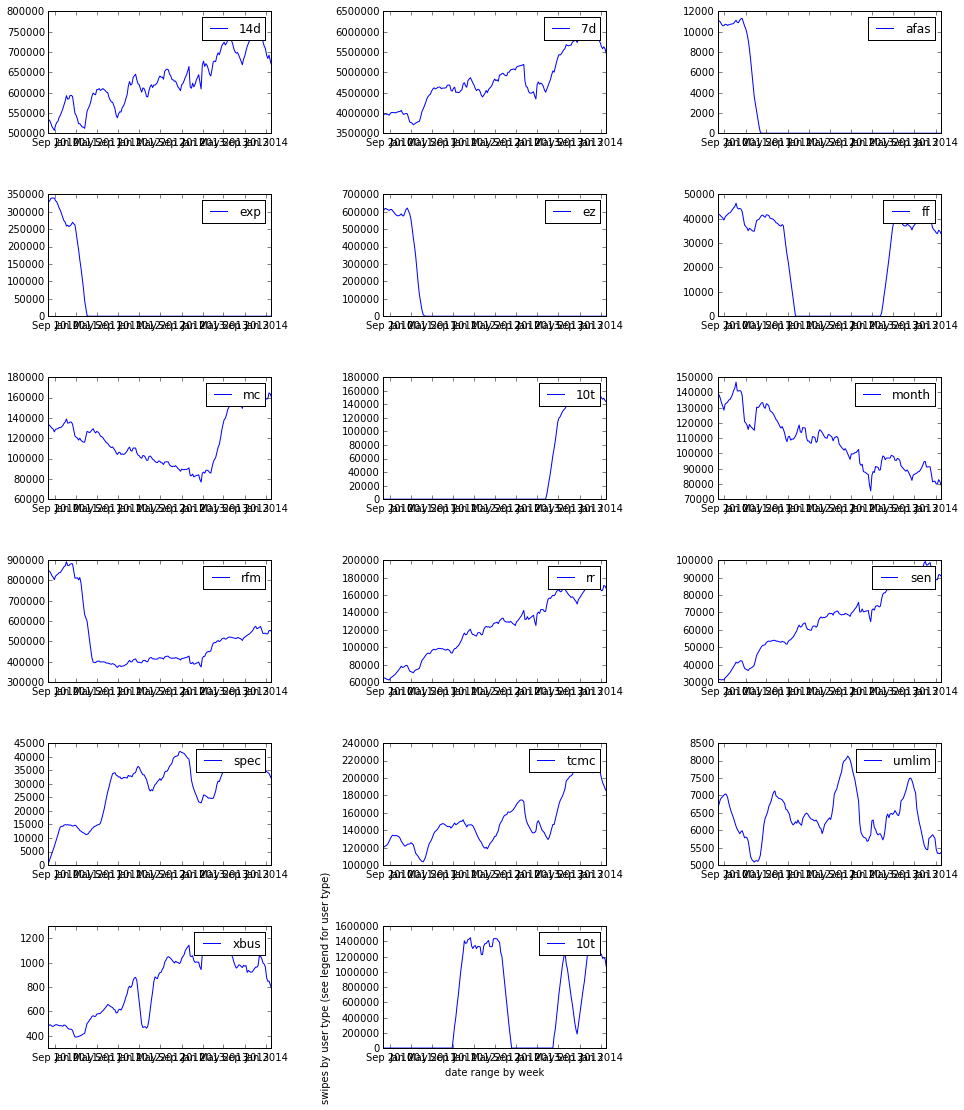

In [29]:
# plotting all fare data types individually to see if trend or change in structure

plt.figure(figsize=(16, 16), dpi=200)
faretype_smooth = pd.rolling_mean(np.transpose(faretype), 10)

pl.subplot(6,3,1)
ax = pl.plot(weekly, faretype_smooth[:, 1])
pl.legend(ridetype[1:])

pl.subplot(6,3,2)
ax = pl.plot(weekly, faretype_smooth[:, 5])
pl.legend(ridetype[5:])

pl.subplot(6,3,3)
ax = pl.plot(weekly, faretype_smooth[:, 7])
pl.legend(ridetype[7:])

pl.subplot(6,3,4)
ax = pl.plot(weekly, faretype_smooth[:, 8])
pl.legend(ridetype[8:])

pl.subplot(6,3,5)
ax = pl.plot(weekly, faretype_smooth[:, 9])
pl.legend(ridetype[9:])

pl.subplot(6,3,6)
ax = pl.plot(weekly, faretype_smooth[:, 10])
pl.legend(ridetype[10:])

pl.subplot(6,3,7)
ax = pl.plot(weekly, faretype_smooth[:, 11])
pl.legend(ridetype[11:])

pl.subplot(6,3,8)
ax = pl.plot(weekly, faretype_smooth[:, 12])
pl.legend(ridetype)

pl.subplot(6,3,9)
ax = pl.plot(weekly, faretype_smooth[:, 13])
pl.legend(ridetype[13:])

pl.subplot(6,3,10)
ax = pl.plot(weekly, faretype_smooth[:, 14])
pl.legend(ridetype[14:])

pl.subplot(6,3,11)
ax = pl.plot(weekly, faretype_smooth[:, 15])
pl.legend(ridetype[15:])

pl.subplot(6,3,12)
ax = pl.plot(weekly, faretype_smooth[:, 16])
pl.legend(ridetype[16:])

pl.subplot(6,3,13)
ax = pl.plot(weekly, faretype_smooth[:, 17])
pl.legend(ridetype[17:])

pl.subplot(6,3,14)
ax = pl.plot(weekly, faretype_smooth[:, 18])
pl.legend(ridetype[18:])

pl.subplot(6,3,15)
ax = pl.plot(weekly, faretype_smooth[:, 20])
pl.legend(ridetype[20:])

pl.subplot(6,3,16)
ax = pl.plot(weekly, faretype_smooth[:, 21])
pl.legend(ridetype[21:])

pl.subplot(6,3,17)
ax = pl.plot(weekly, faretype_smooth[:, 22])
pl.legend(ridetype[22:])

pl.ylabel('swipes by user type (see legend for user type)') # this just puts one label, not every graph...
pl.xlabel('date range by week') # same as y, one label and not every graph...
pl.legend(ridetype)

pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

In [61]:
# received lots of help from classmates on how to do this...
myratios = [1, 5, 13, 15, 16, 17, 18, 21]

for n in myratios:
    if n != 13:
        print ('%s pass types are increasing at a rate of %f. ' % (ridetype[n], rollingratio[n]))
    else: 
        print ('%s pass types are decreasing at a rate of %f. ' % (ridetype[n], rollingratio[n]))

14d pass types are increasing at a rate of 0.796898. 
7d pass types are increasing at a rate of 0.726253. 
month pass types are decreasing at a rate of 1.742226. 
rr pass types are increasing at a rate of 0.387514. 
sen pass types are increasing at a rate of 0.347208. 
spec pass types are increasing at a rate of 0.054637. 
tcmc pass types are increasing at a rate of 0.653060. 
xbus pass types are increasing at a rate of 0.618747. 


**Task 3:**

Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

FB hints:

to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function: 
np.fft.rfft, np.fft.rfft(mydata)

will return the fourier transform, but what you want is its absolute value: np.abs(). 

Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 
np.fft.rfftfreq(N, d) which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling

if you want the freq in units of week that is just 1) the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)

In [32]:
# use the Fourier Transformation to find periodicity, and look at the absolute value

ft = np.abs(np.fft.rfft(swipes))
ft.shape

(600L, 98L)

In [33]:
# finding absolute value

#fourier transform taking absolute values, which is why our array is halved
ffreq = np.fft.rfftfreq(194, d=1.0)
ffreq.shape

(98L,)

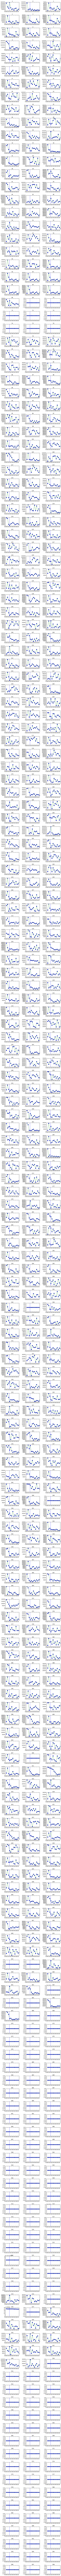

In [34]:
fig = plt.figure(figsize=(10,400))
swipes = pd.DataFrame(swipes)

# creating 600 plots, one for each station, in for loop - DEFINATELY had help with this from classmates :-)
for i in range(600):
    ax = fig.add_subplot(200,3,i+1)
    f = np.abs(np.fft.rfft(swipes.loc[i,:])) 
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms = 8)
    ax.set_title("%i" %(i-1))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52)
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

**Answer:**

Stations -1, 31, 149, 193, and 326 all have an annual periodic event with more than 2.5 million swipes.  Furier does not indicate if these are all the same event, only that a significant increase in swipes occurs annually at these stations.  Since the dataset does not include station names, it cannot be determined if these are located in close proximity or not.

If I had to guess at big, annual events that occur in NYC I would guess New Year's Eve in Times Square; the end of the NYC marathon in Central Park, Macy's Thanksgiving Day Parade, St. Patrick's Day Parade (or maybe Christmas day when no one swipes...)